### 주요내용
    - 처음으로 ReLU함수 사용
    - Local Response Normalization을 사용 (현재는 deprecated됨. Batch Normalization으로 대체)
    - 알렉스 넷의 커널 사이즈가 매우 큼 하지만 deep한 모델을 훈련 성공 --> 이후 논문의 본점은 작은 커널에 집중
    - Maxpooling시 overlapping maxpooling하였음
    - 모델을 두 gpu를 이용하여 훈련시키기 위해 두 갈래로 나눠 구현했는데
    - 현재는 컴퓨텅 파워가 좋아서 한 갈래로도 가능

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils import data

In [2]:
class AlexNet(nn.Module):
    """
    알렉스 넷 논문 구현입니다.
    """
    
    def __init__(self, image_shape, n_classes = 10):
        
        super(AlexNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=image_shape[0], out_channels=96, kernel_size=11, stride=4), # 48*48과 96의 차이는 있지만, 96으로 한번에 구현
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, 5, 4),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        conv_out_size = self._get_conv_out(image_shape)
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(conv_out_size), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features = 4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.ones(1, *shape))
        return int(np.prod(o.size()))  # 모두 곱한 값을 반환

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [3]:
net = AlexNet(image_shape=(3,256,256), n_classes = 10)
net

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(4, 4))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=256, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.

## Reference

- https://taeguu.tistory.com/29

- https://www.quora.com/What-is-local-response-normalization # Local Response Normalization

### 96을 48*48로 나눠서 구현한 것의 효과

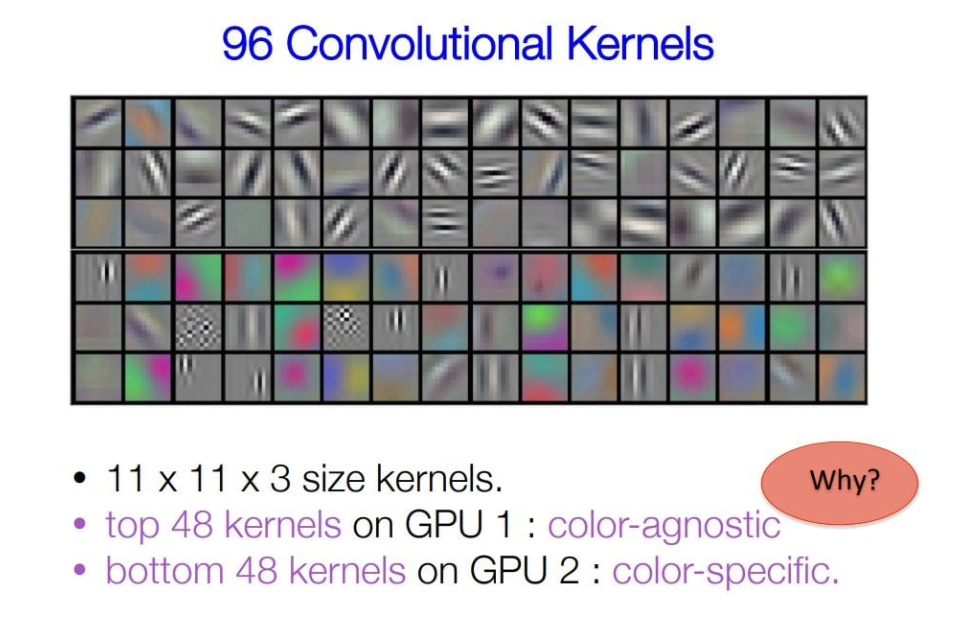

- 96채널을 48채널/48채널로 나누어서 훈련했을 경우의 효과.
    - 위에 48은 color-agnostic 효과를 발견하려고하고
    - 아래의 48은 color-sepecific 효과를 발견하려고 한다.


- 따라서 96채널로 구현하는 것과 48/48 채널로 구현하는 것에는 차이가 있다.

### LRN에 대하여

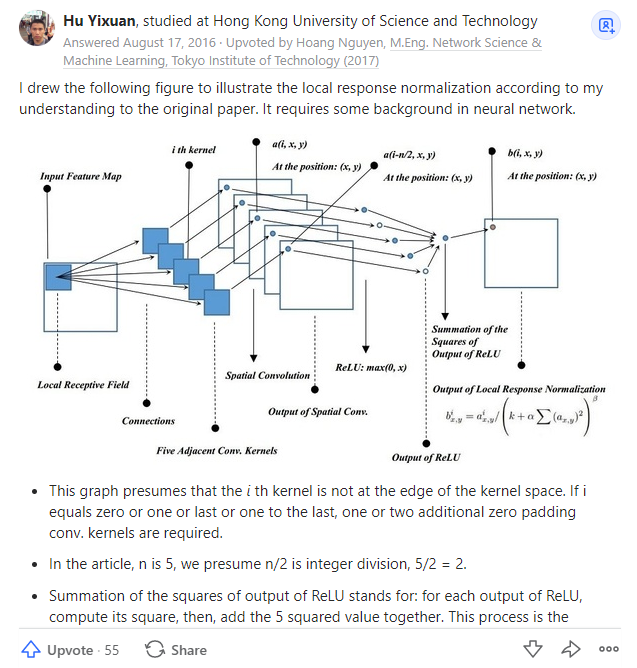